# Teradata DatabaseSpace History Report

This notebook demonstrates how to retrieve database space usage history from Teradata PDCR data using the `PDCRInfoReport` class.

**Report Parameters:**
- Database filter: `DWP01%` (all databases starting with DWP01)
- Time range: Last 3 years
- Data source: `PDCRINFO.DatabaseSpace_Hst`

## 1. Import Required Libraries

Import necessary libraries for PDCR reporting and data analysis.

In [1]:
import logging
import sys
from pathlib import Path
from datetime import date, timedelta
import pandas as pd

# Add src to path for imports
sys.path.insert(0, str(Path.cwd()))

# Import the reporting module
from src.reports import PDCRInfoReport
from src.connection import TeradataConnectionError

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 2. Configure Date Range

Calculate the date range for the last 3 years of data.

In [2]:
# Calculate last 3 years date range
end_date = date.today() - timedelta(days=1)  # Yesterday
start_date = end_date - timedelta(days=3*365)   # 3 years ago

# Database filter pattern
database_pattern = "DWP01%"

print(f"Date Range:")
print(f"  Start Date: {start_date}")
print(f"  End Date:   {end_date}")
print(f"  Database Pattern: {database_pattern}")
print(f"  Days: {(end_date - start_date).days + 1}")

Date Range:
  Start Date: 2023-01-15
  End Date:   2026-01-14
  Database Pattern: DWP01%
  Days: 1096


## 3. Initialize PDCR Report Generator

Create an instance of the `PDCRInfoReport` class to access PDCR data.

In [3]:
try:
    # Initialize the report generator
    report = PDCRInfoReport()
    print("✓ PDCRInfoReport initialized successfully")
    
    # List available environments
    environments = report.conn_mgr.list_environments()
    print(f"✓ Available environments: {environments}")
    
except TeradataConnectionError as e:
    print(f"✗ Connection Error: {e}")
    print("\nPlease ensure:")
    print("1. td_env.yaml file exists in the project root")
    print("2. Copy td_env.yaml.template to td_env.yaml")
    print("3. Update credentials for your test/prod environments")

2026-01-15 08:26:59,181 - src.connection - INFO - Loaded configuration for: ['test', 'prod']


✓ PDCRInfoReport initialized successfully
✓ Available environments: ['test', 'prod']


## 4. Retrieve DatabaseSpace History Data

Query `PDCRINFO.DatabaseSpace_Hst` for all databases starting with `DWP01%` over the last 3 years.

In [4]:
try:
    # Retrieve databasespace history
    df = report.get_databasespace_history(
        env_name='test',  # Change to 'prod' for production data
        start_date=start_date,
        end_date=end_date,
        database_name=database_pattern
    )
    
    print(f"✓ Retrieved {len(df):,} rows from PDCRINFO.DatabaseSpace_Hst")
    print(f"\nDataFrame Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except Exception as e:
    print(f"✗ Error retrieving databasespace data: {e}")
    df = None

2026-01-15 08:26:59,196 - src.reports - INFO - Query Text: 
        SELECT
            LogDate,
            DatabaseName,
            AccountName,
            CURRENTPERM,
            PEAKPERM,
            MAXPERM,
            CURRENTPERMSKEW,
            PERMPCTUSED
        FROM PDCRINFO.DatabaseSpace_Hst
        WHERE Logdate BETWEEN :start_date AND :end_date
          AND TRIM(DatabaseName) LIKE :database_name
        ORDER BY 1, 2, 3;
        
2026-01-15 08:26:59,197 - src.reports - INFO - Fetching DatabaseSpace history for test between 2023-01-15 and 2026-01-14
2026-01-15 08:26:59,198 - src.connection - INFO - Connection string: teradatasql://@teradw/ALL?logmech=BROWSER


Connection string: teradatasql://@teradw/ALL?logmech=BROWSER
2026-01-15 08:27:06,722 INFO sqlalchemy.engine.Engine SELECT dbc.dbcinfov."InfoData" 
FROM dbc.dbcinfov 
WHERE dbc.dbcinfov."InfoKey" = ?


2026-01-15 08:27:06,722 - sqlalchemy.engine.Engine - INFO - SELECT dbc.dbcinfov."InfoData" 
FROM dbc.dbcinfov 
WHERE dbc.dbcinfov."InfoKey" = ?


2026-01-15 08:27:06,724 INFO sqlalchemy.engine.Engine [dialect teradatasql+teradatasql does not support caching 0.00248s] ('VERSION',)


2026-01-15 08:27:06,724 - sqlalchemy.engine.Engine - INFO - [dialect teradatasql+teradatasql does not support caching 0.00248s] ('VERSION',)


2026-01-15 08:27:07,013 INFO sqlalchemy.engine.Engine select database


2026-01-15 08:27:07,013 - sqlalchemy.engine.Engine - INFO - select database


2026-01-15 08:27:07,015 INFO sqlalchemy.engine.Engine [dialect teradatasql+teradatasql does not support caching 0.00163s] ()


2026-01-15 08:27:07,015 - sqlalchemy.engine.Engine - INFO - [dialect teradatasql+teradatasql does not support caching 0.00163s] ()


2026-01-15 08:27:07,100 INFO sqlalchemy.engine.Engine BEGIN (implicit)


2026-01-15 08:27:07,100 - sqlalchemy.engine.Engine - INFO - BEGIN (implicit)


2026-01-15 08:27:07,102 INFO sqlalchemy.engine.Engine SELECT 1


2026-01-15 08:27:07,102 - sqlalchemy.engine.Engine - INFO - SELECT 1


2026-01-15 08:27:07,104 INFO sqlalchemy.engine.Engine [dialect teradatasql+teradatasql does not support caching 0.00377s] ()


2026-01-15 08:27:07,104 - sqlalchemy.engine.Engine - INFO - [dialect teradatasql+teradatasql does not support caching 0.00377s] ()


2026-01-15 08:27:07,167 INFO sqlalchemy.engine.Engine ROLLBACK


2026-01-15 08:27:07,167 - sqlalchemy.engine.Engine - INFO - ROLLBACK
2026-01-15 08:27:07,210 - src.connection - INFO - Created connection to 'test' environment


2026-01-15 08:27:07,254 INFO sqlalchemy.engine.Engine BEGIN (implicit)


2026-01-15 08:27:07,254 - sqlalchemy.engine.Engine - INFO - BEGIN (implicit)


2026-01-15 08:27:07,256 INFO sqlalchemy.engine.Engine SELECT dbc."tablesV"."TableName" 
FROM dbc."tablesV" 
WHERE DatabaseName (NOT CASESPECIFIC) = ? (NOT CASESPECIFIC) AND TableName=? AND TableKind IN ('O', 'Q', 'T', 'V')


2026-01-15 08:27:07,256 - sqlalchemy.engine.Engine - INFO - SELECT dbc."tablesV"."TableName" 
FROM dbc."tablesV" 
WHERE DatabaseName (NOT CASESPECIFIC) = ? (NOT CASESPECIFIC) AND TableName=? AND TableKind IN ('O', 'Q', 'T', 'V')


2026-01-15 08:27:07,257 INFO sqlalchemy.engine.Engine [dialect teradatasql+teradatasql does not support caching 0.00293s] ('ALL', <sqlalchemy.sql.elements.TextClause object at 0x00000247BD78CE10>)


2026-01-15 08:27:07,257 - sqlalchemy.engine.Engine - INFO - [dialect teradatasql+teradatasql does not support caching 0.00293s] ('ALL', <sqlalchemy.sql.elements.TextClause object at 0x00000247BD78CE10>)


2026-01-15 08:27:07,259 INFO sqlalchemy.engine.Engine 
        SELECT
            LogDate,
            DatabaseName,
            AccountName,
            CURRENTPERM,
            PEAKPERM,
            MAXPERM,
            CURRENTPERMSKEW,
            PERMPCTUSED
        FROM PDCRINFO.DatabaseSpace_Hst
        WHERE Logdate BETWEEN ? AND ?
          AND TRIM(DatabaseName) LIKE ?
        ORDER BY 1, 2, 3;
        


2026-01-15 08:27:07,259 - sqlalchemy.engine.Engine - INFO - 
        SELECT
            LogDate,
            DatabaseName,
            AccountName,
            CURRENTPERM,
            PEAKPERM,
            MAXPERM,
            CURRENTPERMSKEW,
            PERMPCTUSED
        FROM PDCRINFO.DatabaseSpace_Hst
        WHERE Logdate BETWEEN ? AND ?
          AND TRIM(DatabaseName) LIKE ?
        ORDER BY 1, 2, 3;
        


2026-01-15 08:27:07,260 INFO sqlalchemy.engine.Engine [dialect teradatasql+teradatasql does not support caching 0.00134s] ('2023-01-15', '2026-01-14', 'DWP01%')


2026-01-15 08:27:07,260 - sqlalchemy.engine.Engine - INFO - [dialect teradatasql+teradatasql does not support caching 0.00134s] ('2023-01-15', '2026-01-14', 'DWP01%')


2026-01-15 08:27:22,264 INFO sqlalchemy.engine.Engine ROLLBACK


2026-01-15 08:27:22,264 - sqlalchemy.engine.Engine - INFO - ROLLBACK


✓ Retrieved 128,160 rows from PDCRINFO.DatabaseSpace_Hst

DataFrame Shape: (128160, 8)
Memory Usage: 25.03 MB


## 5. Display Sample Data

Preview the first few rows to understand the data structure.

In [5]:
if df is not None and not df.empty:
    print("First 10 rows:")
    display(df.head(10))
    
    print("\nColumn Data Types:")
    print(df.dtypes)
else:
    print("No data available to display.")

First 10 rows:


,LogDate,DatabaseName,AccountName,CURRENTPERM,PEAKPERM,MAXPERM,CURRENTPERMSKEW,PERMPCTUSED
0,2023-01-15,DWP01F_APP_EHR,$M00DBAB&D&H,0.000000e+00,0.000000e+00,1.048576e+08,NaN,0.000000
1,2023-01-15,DWP01P_APP_EHR,$M00DBAB&D&H,7.416218e+07,0.000000e+00,1.073742e+09,22.225086,6.906891
2,2023-01-15,DWP01P_MET,$H00DBAB&D&H,7.700480e+05,0.000000e+00,1.048576e+08,60.833333,0.734375
3,2023-01-15,DWP01T_ACC_AFF,$H00DBAB&D&H,1.791571e+11,0.000000e+00,2.205716e+11,3.319273,81.224013
4,2023-01-15,DWP01T_ACC_BNM,$H00DBAB&D&H,1.389551e+11,1.390602e+11,1.590716e+11,0.090610,87.353828
5,2023-01-15,DWP01T_ACC_FIN,$H00DBAB&D&H,3.423751e+11,3.590595e+11,4.460039e+11,10.453775,76.765054
6,2023-01-15,DWP01T_ACC_GLOBL_TMP,$M00DBAB&D&H,1.638400e+06,0.000000e+00,1.048576e+07,0.000000,15.625000
7,2023-01-15,DWP01T_ACC_ODS,$H00DBAB&D&H,4.474742e+10,4.474742e+10,7.724009e+10,2.033621,57.932888
8,2023-01-15,DWP01T_ACC_OLR,$H00DBAB&D&H,6.484402e+09,6.510522e+09,1.610613e+10,0.252911,40.260468
9,2023-01-15,DWP01T_ACC_ORR,$L00DUSR&D&H,5.701909e+12,5.702118e+12,5.851314e+12,0.034863,97.446649



Column Data Types:
LogDate             object
DatabaseName        object
AccountName         object
CURRENTPERM        float64
PEAKPERM           float64
MAXPERM            float64
CURRENTPERMSKEW    float64
PERMPCTUSED        float64
dtype: object


## 6. Data Summary Statistics

Analyze the databasespace usage across all retrieved data.

In [6]:
if df is not None and not df.empty:
    print("=" * 80)
    print("DATABASESPACE SUMMARY STATISTICS")
    print("=" * 80)
    
    # Date range
    print(f"\nDate Range:")
    print(f"  First Log Date: {df['LogDate'].min()}")
    print(f"  Last Log Date:  {df['LogDate'].max()}")
    print(f"  Unique Dates:   {df['LogDate'].nunique()}")
    
    # Database coverage
    print(f"\nDatabase Coverage:")
    print(f"  Unique Databases: {df['DatabaseName'].nunique()}")
    print(f"  Unique Accounts:  {df['AccountName'].nunique()}")
    
    # Space usage statistics (in bytes, convert to GB)
    print(f"\nCurrent Perm Usage (GB):")
    print(f"  Total:   {df['CURRENTPERM'].sum() / 1024**3:,.2f}")
    print(f"  Mean:    {df['CURRENTPERM'].mean() / 1024**3:,.2f}")
    print(f"  Median:  {df['CURRENTPERM'].median() / 1024**3:,.2f}")
    print(f"  Max:     {df['CURRENTPERM'].max() / 1024**3:,.2f}")
    
    print(f"\nPeak Perm Usage (GB):")
    print(f"  Total:   {df['PEAKPERM'].sum() / 1024**3:,.2f}")
    print(f"  Mean:    {df['PEAKPERM'].mean() / 1024**3:,.2f}")
    print(f"  Median:  {df['PEAKPERM'].median() / 1024**3:,.2f}")
    print(f"  Max:     {df['PEAKPERM'].max() / 1024**3:,.2f}")
    
    print(f"\nMax Perm Usage (GB):")
    print(f"  Total:   {df['MAXPERM'].sum() / 1024**3:,.2f}")
    print(f"  Mean:    {df['MAXPERM'].mean() / 1024**3:,.2f}")
    print(f"  Median:  {df['MAXPERM'].median() / 1024**3:,.2f}")
    print(f"  Max:     {df['MAXPERM'].max() / 1024**3:,.2f}")
    
    # Skew and usage statistics
    print(f"\nSkew Statistics:")
    print(f"  Avg Current Skew: {df['CURRENTPERMSKEW'].mean():.2f}%")
    print(f"  Max Current Skew: {df['CURRENTPERMSKEW'].max():.2f}%")
    
    print(f"\nPerm Usage Percentage:")
    print(f"  Avg PERMPCTUSED: {df['PERMPCTUSED'].mean():.2f}%")
    print(f"  Max PERMPCTUSED: {df['PERMPCTUSED'].max():.2f}%")
else:
    print("No data available for analysis.")

DATABASESPACE SUMMARY STATISTICS

Date Range:
  First Log Date: 2023-01-15
  Last Log Date:  2026-01-14
  Unique Dates:   1089

Database Coverage:
  Unique Databases: 126
  Unique Accounts:  3

Current Perm Usage (GB):
  Total:   29,214,789.55
  Mean:    227.96
  Median:  0.10
  Max:     19,788.22

Peak Perm Usage (GB):
  Total:   28,615,898.55
  Mean:    223.28
  Median:  0.01
  Max:     19,790.67

Max Perm Usage (GB):
  Total:   32,587,612.15
  Mean:    254.27
  Median:  3.07
  Max:     21,141.41

Skew Statistics:
  Avg Current Skew: 13.32%
  Max Current Skew: 94.60%

Perm Usage Percentage:
  Avg PERMPCTUSED: 26.92%
  Max PERMPCTUSED: 99.94%


## 7. Top Databases by Current Space Usage

Identify the largest databases by current permanent space usage.

In [7]:
if df is not None and not df.empty:
    # Get the most recent data for each database
    latest_data = df.loc[df.groupby('DatabaseName')['LogDate'].idxmax()]
    
    # Sort by current perm usage
    top_dbs = latest_data.nlargest(20, 'CURRENTPERM')[[
        'DatabaseName', 'AccountName', 
        'CURRENTPERM', 'PEAKPERM', 'MAXPERM', 'CURRENTPERMSKEW', 'PERMPCTUSED'
    ]].copy()
    
    # Convert to GB for readability
    top_dbs['CURRENTPERM_GB'] = top_dbs['CURRENTPERM'] / 1024**3
    top_dbs['PEAKPERM_GB'] = top_dbs['PEAKPERM'] / 1024**3
    top_dbs['MAXPERM_GB'] = top_dbs['MAXPERM'] / 1024**3
    
    print("\nTop 20 Databases by Current Permanent Space Usage:")
    print("=" * 120)
    display(top_dbs[[
        'DatabaseName', 'CURRENTPERM_GB', 'PEAKPERM_GB', 'MAXPERM_GB',
        'CURRENTPERMSKEW', 'PERMPCTUSED'
    ]].sort_values('CURRENTPERM_GB', ascending=False))
else:
    print("No data available for database ranking.")


Top 20 Databases by Current Permanent Space Usage:


,DatabaseName,CURRENTPERM_GB,PEAKPERM_GB,MAXPERM_GB,CURRENTPERMSKEW,PERMPCTUSED
128044,DWP01T_ACC_ORR,19611.144428,19611.144428,21141.413156,0.019957,92.761748
128086,DWP01T_SRCI_RMS,7231.256252,7231.256252,7760.797344,0.111204,93.176718
128062,DWP01T_IDW,5768.101250,5768.101250,6268.085349,0.087848,92.023336
128069,DWP01T_SRCI_AOM,3244.967831,3244.967831,3532.081260,0.036234,91.871268
128083,DWP01T_SRCI_OFA,662.471001,662.515095,738.164612,0.814282,89.745700
128109,DWP01T_TMP_ACC,516.337803,610.378052,764.341919,0.709117,67.553249
128047,DWP01T_ACC_RTL,501.228310,501.228310,659.642208,0.322229,75.984875
128068,DWP01T_SKEY,497.247696,497.247696,543.487003,0.076017,91.492104
128130,DWP01T_TMP_RMS,229.898827,373.893600,439.488770,0.358541,52.310512
128054,DWP01T_APP_EHR_DBO,206.946972,0.000000,222.853638,0.075587,92.862281


## 8. Database-Level Aggregation

Get summary statistics for each database showing growth trends.

In [8]:
if df is not None and not df.empty:
    # Get most recent data
    latest_data = df.loc[df.groupby('DatabaseName')['LogDate'].idxmax()]
    
    # Aggregate by database
    db_summary = latest_data.groupby('DatabaseName').agg({
        'CURRENTPERM': 'first',
        'PEAKPERM': 'first',
        'MAXPERM': 'first',
        'CURRENTPERMSKEW': 'first',
        'PERMPCTUSED': 'first'
    }).round(2)
    
    # Convert to GB
    db_summary['CURRENTPERM_GB'] = (db_summary['CURRENTPERM'] / 1024**3).round(2)
    db_summary['PEAKPERM_GB'] = (db_summary['PEAKPERM'] / 1024**3).round(2)
    db_summary['MAXPERM_GB'] = (db_summary['MAXPERM'] / 1024**3).round(2)
    
    # Sort by current usage
    db_summary = db_summary.sort_values('CURRENTPERM_GB', ascending=False)
    
    print("\nDatabase-Level Space Usage Summary (Latest):")
    print("=" * 100)
    display(db_summary[['CURRENTPERM_GB', 'PEAKPERM_GB', 'MAXPERM_GB', 'CURRENTPERMSKEW', 'PERMPCTUSED']])
    
    print(f"\nTotal Space Across All DWP01% Databases: {db_summary['CURRENTPERM_GB'].sum():,.2f} GB")
else:
    print("No data available for database aggregation.")


Database-Level Space Usage Summary (Latest):


,CURRENTPERM_GB,PEAKPERM_GB,MAXPERM_GB,CURRENTPERMSKEW,PERMPCTUSED
DatabaseName,,,,,
DWP01T_ACC_ORR,19611.14,19611.14,21141.41,0.02,92.76
DWP01T_SRCI_RMS,7231.26,7231.26,7760.80,0.11,93.18
DWP01T_IDW,5768.10,5768.10,6268.09,0.09,92.02
DWP01T_SRCI_AOM,3244.97,3244.97,3532.08,0.04,91.87
DWP01T_SRCI_OFA,662.47,662.52,738.16,0.81,89.75
...,...,...,...,...,...
DWP01T_WRK_UNF,0.00,0.00,1.00,NaN,0.00
DWP01V_IDW,0.00,0.00,0.95,NaN,0.00
DWP01V_MET,0.00,0.00,0.47,NaN,0.00



Total Space Across All DWP01% Databases: 39,808.41 GB


## 9. Visualize Database Space Usage

Visualize the top databases by current permanent space usage using a bar chart.

C:\Users\cwatts\AppData\Local\Temp\ipykernel_34876\2051531813.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


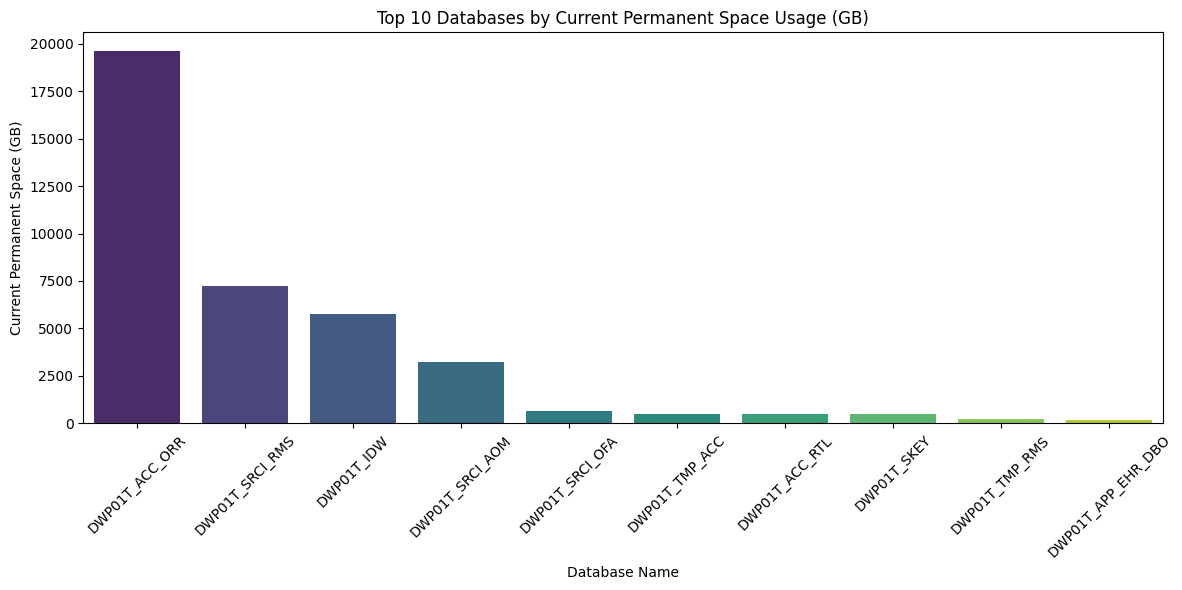

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

if df is not None and not df.empty:
    # Get most recent data
    latest_data = df.loc[df.groupby('DatabaseName')['LogDate'].idxmax()]

    # Get top 10 databases
    top_dbs = latest_data.nlargest(10, 'CURRENTPERM')[['DatabaseName', 'CURRENTPERM']].copy()
    top_dbs['CURRENTPERM_GB'] = top_dbs['CURRENTPERM'] / 1024**3

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_dbs,
        x='DatabaseName',
        y='CURRENTPERM_GB',
        palette='viridis'
    )
    plt.title('Top 10 Databases by Current Permanent Space Usage (GB)')
    plt.xlabel('Database Name')
    plt.ylabel('Current Permanent Space (GB)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 10. Space Usage Trends Over Time

Plot total space usage for all databases over the 3-year period.

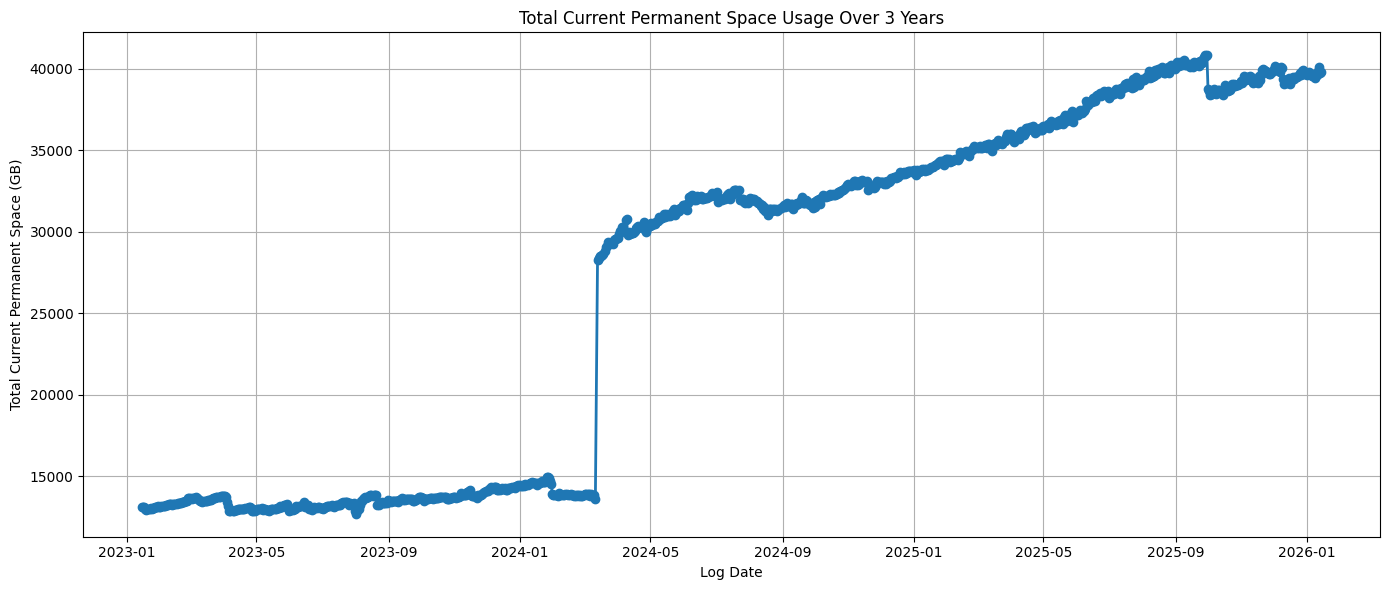

In [10]:
# Plot total space usage over time
import matplotlib.pyplot as plt

if df is not None and not df.empty:
    df_databases_over_time = df.groupby(['LogDate'])['CURRENTPERM'].sum().reset_index()
    plt.figure(figsize=(14, 6))
    plt.plot(df_databases_over_time['LogDate'], df_databases_over_time['CURRENTPERM'] / 1024**3, marker='o', linewidth=2)
    plt.title('Total Current Permanent Space Usage Over 3 Years')
    plt.xlabel('Log Date')
    plt.ylabel('Total Current Permanent Space (GB)')
    plt.grid()
    plt.tight_layout()
    plt.show()

## 11. Database Space Usage Distribution

Pie chart showing space distribution among top databases.

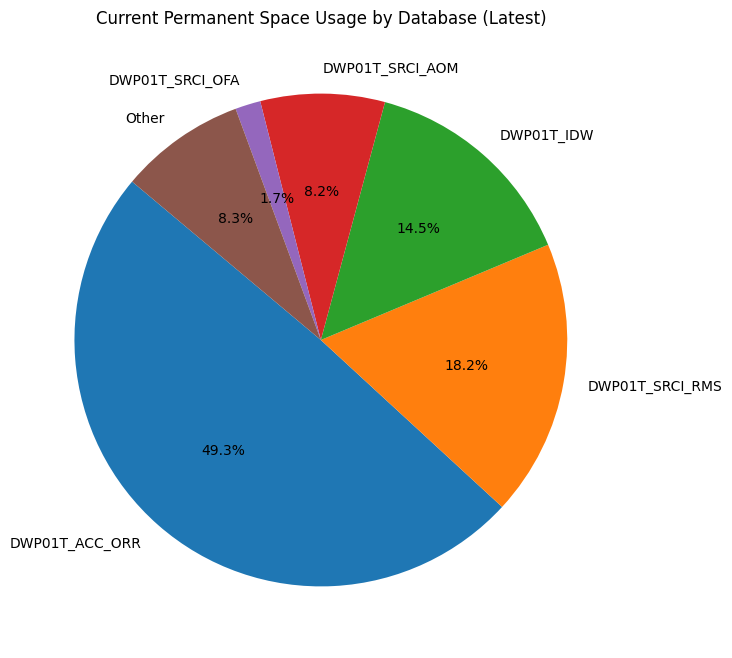

In [11]:
# Plot as pie chart per database usage
import matplotlib.pyplot as plt

if df is not None and not df.empty:
    df_latest = df.loc[df.groupby('DatabaseName')['LogDate'].idxmax()]
    df_db_usage = df_latest.groupby('DatabaseName')['CURRENTPERM'].sum().reset_index()
    df_db_usage = df_db_usage.sort_values('CURRENTPERM', ascending=False)
    
    top_n = 5
    df_top = df_db_usage.head(top_n)
    df_other = pd.DataFrame({
        'DatabaseName': ['Other'],
        'CURRENTPERM': [df_db_usage['CURRENTPERM'][top_n:].sum()]
    })
    df_pie = pd.concat([df_top, df_other])
    
    plt.figure(figsize=(10, 8))
    plt.pie(
        df_pie['CURRENTPERM'],
        labels=df_pie['DatabaseName'],
        autopct='%1.1f%%',
        startangle=140
    )
    plt.title('Current Permanent Space Usage by Database (Latest)')
    plt.show()

## 12. Top Database Growth Analysis

Analyze space growth trends for the top 6 databases over time.

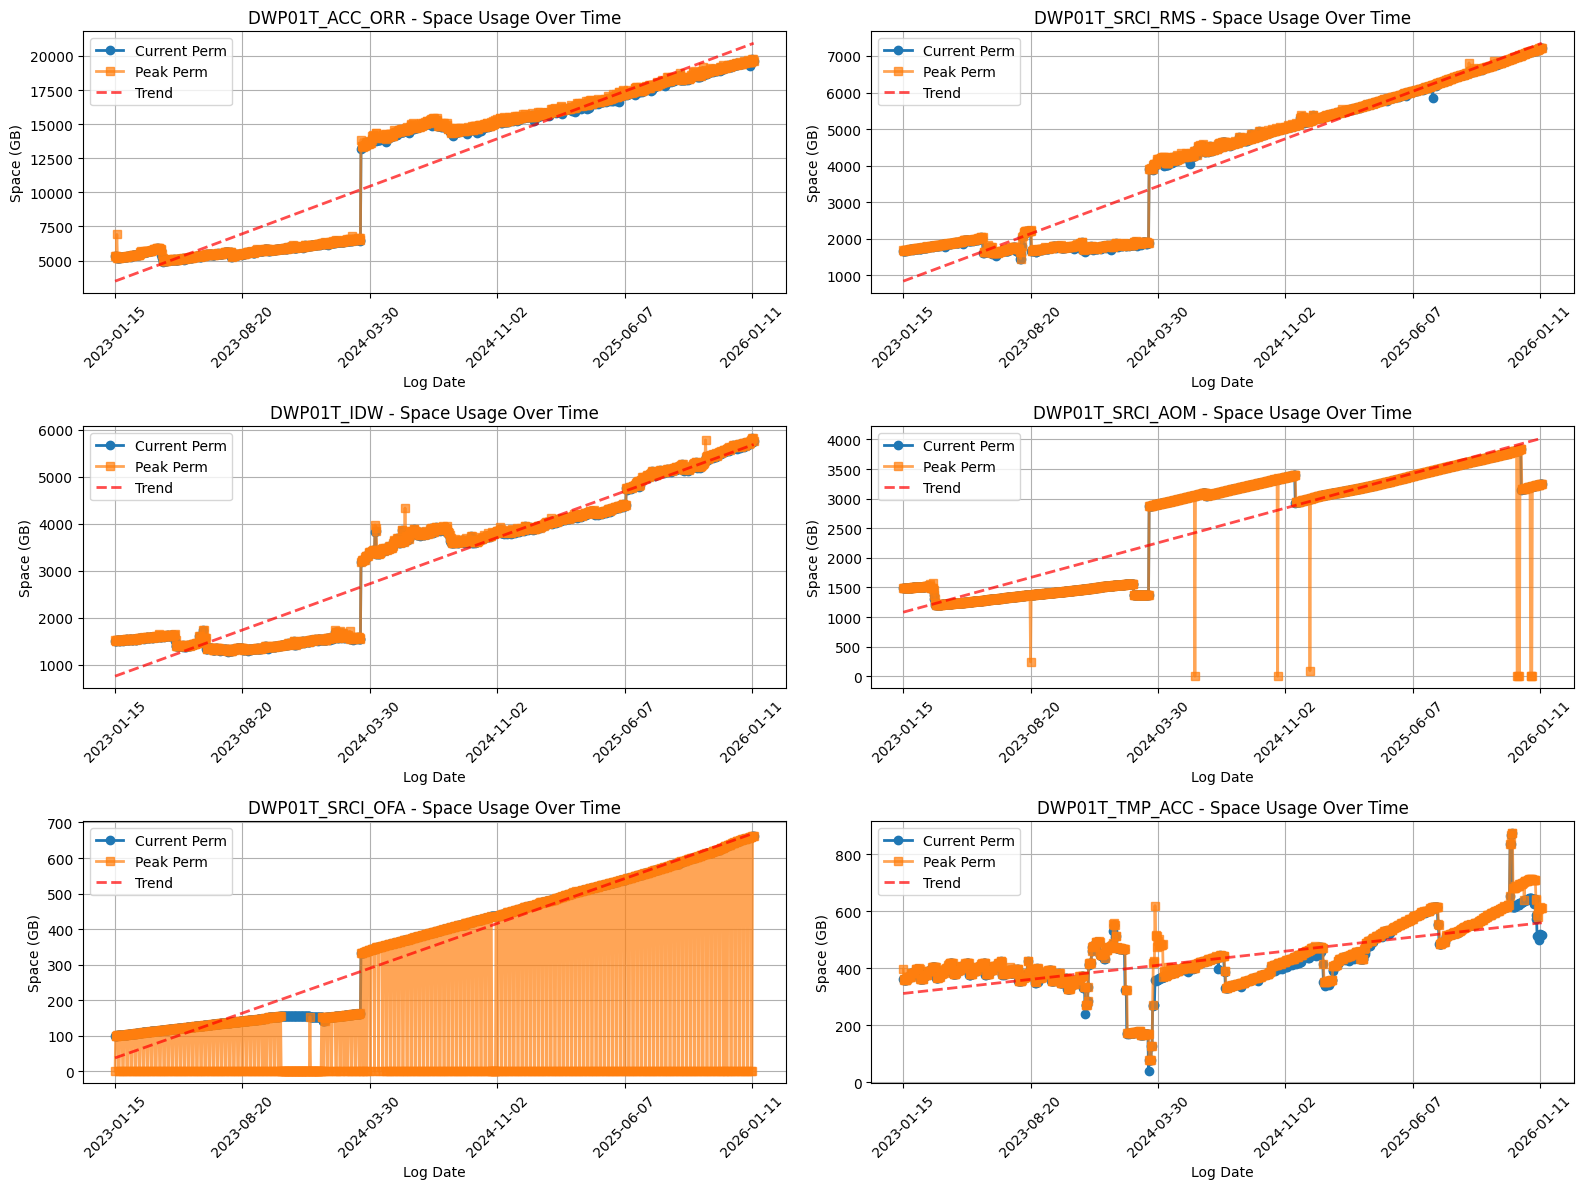

In [14]:
# Plot the space usage of the top 6 databases over time in subplots
import matplotlib.pyplot as plt
import numpy as np
if df is not None and not df.empty:
    df_latest = df.loc[df.groupby('DatabaseName')['LogDate'].idxmax()]
    top_dbs = df_latest.nlargest(6, 'CURRENTPERM')['DatabaseName'].tolist()
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, db_name in enumerate(top_dbs):
        ax = axes[i]
        df_db = df[df['DatabaseName'] == db_name].sort_values('LogDate').reset_index(drop=True)
        
        # Plot the data
        ax.plot(df_db.index, df_db['CURRENTPERM'] / 1024**3, marker='o', label='Current Perm', linewidth=2)
        ax.plot(df_db.index, df_db['PEAKPERM'] / 1024**3, marker='s', label='Peak Perm', linewidth=2, alpha=0.7)
        
        # Add a regression line for trend
        if len(df_db) > 1:
            z = np.polyfit(df_db.index, df_db['CURRENTPERM'] / 1024**3, 1)
            p = np.poly1d(z)
            ax.plot(df_db.index, p(df_db.index), "r--", alpha=0.7, label='Trend', linewidth=2)
        
        # Set x-axis labels to show dates
        ax.set_xticks(df_db.index[::max(1, len(df_db)//5)])
        ax.set_xticklabels([str(d) for d in df_db.loc[df_db.index[::max(1, len(df_db)//5)], 'LogDate']], rotation=45)
        
        ax.set_title(f'{db_name} - Space Usage Over Time')
        ax.set_xlabel('Log Date')
        ax.set_ylabel('Space (GB)')
        ax.grid()
        ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for growth analysis.")

In [ ]:
import numpy as np

## 13. Export Results to CSV (Optional)

Save the results to CSV files for further analysis or reporting.

In [ ]:
if df is not None and not df.empty:
    # Create output directory if it doesn't exist
    output_dir = Path('output')
    output_dir.mkdir(exist_ok=True)
    
    # Generate filename with date range
    filename = f"databasespace_dwp01_{start_date}_{end_date}.csv"
    output_path = output_dir / filename
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"✓ Data exported to: {output_path}")
    print(f"  Rows: {len(df):,}")
    print(f"  File size: {output_path.stat().st_size / 1024**2:.2f} MB")
else:
    print("No data to export.")

## 14. Close Connections

Properly clean up database connections when done.

In [ ]:
try:
    if 'report' in locals():
        report.close()
        print("✓ All database connections closed successfully")
    else:
        print("No report instance to close")
except Exception as e:
    print(f"✗ Error closing connections: {e}")